# Notebook 06 : Optimisation des Hyperparamètres
## Grid Search CV + Cross-Validation sur les Meilleurs Modèles



### Modèles optimisés :
| # | Modèle | Hyperparamètres |
|---|--------|------------------|
| 1 | **Random Forest** | n_estimators, max_depth, min_samples_split, min_samples_leaf |
| 2 | **XGBoost** | n_estimators, learning_rate, max_depth, subsample, colsample_bytree |
| 3 | **SVM (RBF)** | C, gamma, kernel |


## 1. Configuration et Imports

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# MLflow
import mlflow
import mlflow.sklearn

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

COLORS = {'before': '#E74C3C', 'after': '#2ECC71', 'primary': '#3498DB'}

print(f"Configuration terminée - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Configuration terminée - 2026-02-13 18:15:56


## 2. Configuration MLflow

In [2]:
# ============================================================================
# CONFIGURATION MLFLOW
# ============================================================================

mlflow.set_tracking_uri("file:./mlruns")
EXPERIMENT_NAME = "Heart_Disease_Hyperparameter_Tuning"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment: {EXPERIMENT_NAME}")

MLflow Experiment: Heart_Disease_Hyperparameter_Tuning


## 3. Chargement des Données

In [3]:
# ============================================================================
# CHARGEMENT ET PRÉPARATION
# ============================================================================

df = pd.read_csv('heart.csv')
X = df.drop('target', axis=1)
y = df['target']
feature_names = X.columns.tolist()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"Dataset: {len(df)} patients | Train: {len(X_train)} | Test: {len(X_test)}")

Dataset: 1025 patients | Train: 820 | Test: 205


## 4. Fonction d'Évaluation

In [4]:
# ============================================================================
# FONCTION D'ÉVALUATION
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Entraîne et évalue un modèle."""
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred
    }

# Stockage des résultats
results_before = {}
results_after = {}
best_models = {}
tuning_history = []

---

## 5. Random Forest - Optimisation

In [5]:
print("="*70)
print("MODÈLE 1 : RANDOM FOREST")
print("="*70)

# ---- AVANT OPTIMISATION ----
print("\n[AVANT] Paramètres par défaut...")
rf_default = RandomForestClassifier(random_state=RANDOM_STATE)
results_before['Random_Forest'] = evaluate_model(
    rf_default, X_train_scaled, X_test_scaled, y_train, y_test
)
print(f"  Accuracy: {results_before['Random_Forest']['accuracy']:.4f}")
print(f"  F1-Score: {results_before['Random_Forest']['f1']:.4f}")
print(f"  ROC-AUC:  {results_before['Random_Forest']['roc_auc']:.4f}")

MODÈLE 1 : RANDOM FOREST

[AVANT] Paramètres par défaut...
  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000


In [6]:
# ---- GRID SEARCH ----
print("\n[GRID SEARCH] Optimisation en cours...")

rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"  Combinaisons à tester: {np.prod([len(v) for v in rf_param_grid.values()])}")

with mlflow.start_run(run_name="RF_GridSearch"):
    start_time = time.time()
    
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        rf_param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    rf_grid.fit(X_train_scaled, y_train)
    
    tuning_time = time.time() - start_time
    
    # Log MLflow
    mlflow.log_param("model", "Random_Forest")
    mlflow.log_param("search_type", "GridSearchCV")
    mlflow.log_param("cv_folds", 5)
    mlflow.log_params(rf_grid.best_params_)
    
    mlflow.log_metric("best_cv_score", rf_grid.best_score_)
    mlflow.log_metric("tuning_time", tuning_time)
    
    print(f"\n  Temps: {tuning_time:.2f}s")
    print(f"  Meilleur score CV: {rf_grid.best_score_:.4f}")
    print(f"  Meilleurs paramètres: {rf_grid.best_params_}")


[GRID SEARCH] Optimisation en cours...
  Combinaisons à tester: 360
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

  Temps: 236.65s
  Meilleur score CV: 0.9824
  Meilleurs paramètres: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [7]:
# ---- APRÈS OPTIMISATION ----
print("\n[APRÈS] Évaluation du modèle optimisé...")

rf_best = rf_grid.best_estimator_
results_after['Random_Forest'] = evaluate_model(
    rf_best, X_train_scaled, X_test_scaled, y_train, y_test
)
best_models['Random_Forest'] = rf_best

# Log final
with mlflow.start_run(run_name="RF_Optimized"):
    mlflow.log_params(rf_grid.best_params_)
    mlflow.log_metric("accuracy", results_after['Random_Forest']['accuracy'])
    mlflow.log_metric("f1_score", results_after['Random_Forest']['f1'])
    mlflow.log_metric("roc_auc", results_after['Random_Forest']['roc_auc'])
    mlflow.sklearn.log_model(rf_best, "random_forest_optimized")

print(f"  Accuracy: {results_after['Random_Forest']['accuracy']:.4f}")
print(f"  F1-Score: {results_after['Random_Forest']['f1']:.4f}")
print(f"  ROC-AUC:  {results_after['Random_Forest']['roc_auc']:.4f}")

# Amélioration
acc_diff = results_after['Random_Forest']['accuracy'] - results_before['Random_Forest']['accuracy']
print(f"\n  \u0394 Accuracy: {acc_diff:+.4f}")


[APRÈS] Évaluation du modèle optimisé...


2026/02/13 18:19:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000

  Δ Accuracy: +0.0000


## 6. XGBoost - Optimisation

In [8]:
print("\n" + "="*70)
print("MODÈLE 2 : XGBOOST")
print("="*70)

# ---- AVANT OPTIMISATION ----
print("\n[AVANT] Paramètres par défaut...")
xgb_default = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
results_before['XGBoost'] = evaluate_model(
    xgb_default, X_train_scaled, X_test_scaled, y_train, y_test
)
print(f"  Accuracy: {results_before['XGBoost']['accuracy']:.4f}")
print(f"  F1-Score: {results_before['XGBoost']['f1']:.4f}")
print(f"  ROC-AUC:  {results_before['XGBoost']['roc_auc']:.4f}")


MODÈLE 2 : XGBOOST

[AVANT] Paramètres par défaut...
  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000


In [9]:
# ---- GRID SEARCH ----
print("\n[GRID SEARCH] Optimisation en cours...")

xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

print(f"  Combinaisons à tester: {np.prod([len(v) for v in xgb_param_grid.values()])}")
print("  (Utilisation de RandomizedSearchCV pour réduire le temps)")

with mlflow.start_run(run_name="XGB_GridSearch"):
    start_time = time.time()
    
    xgb_grid = RandomizedSearchCV(
        XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, 
                      eval_metric='logloss', verbosity=0),
        xgb_param_grid,
        n_iter=50,  # 50 combinaisons aléatoires
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE
    )
    xgb_grid.fit(X_train_scaled, y_train)
    
    tuning_time = time.time() - start_time
    
    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("search_type", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 50)
    mlflow.log_params(xgb_grid.best_params_)
    mlflow.log_metric("best_cv_score", xgb_grid.best_score_)
    mlflow.log_metric("tuning_time", tuning_time)
    
    print(f"\n  Temps: {tuning_time:.2f}s")
    print(f"  Meilleur score CV: {xgb_grid.best_score_:.4f}")
    print(f"  Meilleurs paramètres: {xgb_grid.best_params_}")


[GRID SEARCH] Optimisation en cours...
  Combinaisons à tester: 576
  (Utilisation de RandomizedSearchCV pour réduire le temps)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

  Temps: 9.59s
  Meilleur score CV: 0.9870
  Meilleurs paramètres: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [10]:
# ---- APRÈS OPTIMISATION ----
print("\n[APRÈS] Évaluation du modèle optimisé...")

xgb_best = xgb_grid.best_estimator_
results_after['XGBoost'] = evaluate_model(
    xgb_best, X_train_scaled, X_test_scaled, y_train, y_test
)
best_models['XGBoost'] = xgb_best

with mlflow.start_run(run_name="XGB_Optimized"):
    mlflow.log_params(xgb_grid.best_params_)
    mlflow.log_metric("accuracy", results_after['XGBoost']['accuracy'])
    mlflow.log_metric("f1_score", results_after['XGBoost']['f1'])
    mlflow.log_metric("roc_auc", results_after['XGBoost']['roc_auc'])
    mlflow.sklearn.log_model(xgb_best, "xgboost_optimized")

print(f"  Accuracy: {results_after['XGBoost']['accuracy']:.4f}")
print(f"  F1-Score: {results_after['XGBoost']['f1']:.4f}")
print(f"  ROC-AUC:  {results_after['XGBoost']['roc_auc']:.4f}")

acc_diff = results_after['XGBoost']['accuracy'] - results_before['XGBoost']['accuracy']
print(f"\n  \u0394 Accuracy: {acc_diff:+.4f}")


[APRÈS] Évaluation du modèle optimisé...


2026/02/13 18:20:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000

  Δ Accuracy: +0.0000


## 7. SVM (RBF) - Optimisation

In [11]:
print("\n" + "="*70)
print("MODÈLE 3 : SVM (RBF KERNEL)")
print("="*70)

# ---- AVANT OPTIMISATION ----
print("\n[AVANT] Paramètres par défaut...")
svm_default = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
results_before['SVM'] = evaluate_model(
    svm_default, X_train_scaled, X_test_scaled, y_train, y_test
)
print(f"  Accuracy: {results_before['SVM']['accuracy']:.4f}")
print(f"  F1-Score: {results_before['SVM']['f1']:.4f}")
print(f"  ROC-AUC:  {results_before['SVM']['roc_auc']:.4f}")


MODÈLE 3 : SVM (RBF KERNEL)

[AVANT] Paramètres par défaut...
  Accuracy: 0.9268
  F1-Score: 0.9296
  ROC-AUC:  0.9771


In [12]:
# ---- GRID SEARCH ----
print("\n[GRID SEARCH] Optimisation en cours...")

svm_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

print(f"  Combinaisons à tester: {np.prod([len(v) for v in svm_param_grid.values()])}")

with mlflow.start_run(run_name="SVM_GridSearch"):
    start_time = time.time()
    
    svm_grid = GridSearchCV(
        SVC(probability=True, random_state=RANDOM_STATE),
        svm_param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    svm_grid.fit(X_train_scaled, y_train)
    
    tuning_time = time.time() - start_time
    
    mlflow.log_param("model", "SVM")
    mlflow.log_param("search_type", "GridSearchCV")
    mlflow.log_params(svm_grid.best_params_)
    mlflow.log_metric("best_cv_score", svm_grid.best_score_)
    mlflow.log_metric("tuning_time", tuning_time)
    
    print(f"\n  Temps: {tuning_time:.2f}s")
    print(f"  Meilleur score CV: {svm_grid.best_score_:.4f}")
    print(f"  Meilleurs paramètres: {svm_grid.best_params_}")


[GRID SEARCH] Optimisation en cours...
  Combinaisons à tester: 90
Fitting 5 folds for each of 90 candidates, totalling 450 fits

  Temps: 12.21s
  Meilleur score CV: 0.9783
  Meilleurs paramètres: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
# ---- APRÈS OPTIMISATION ----
print("\n[APRÈS] Évaluation du modèle optimisé...")

svm_best = svm_grid.best_estimator_
results_after['SVM'] = evaluate_model(
    svm_best, X_train_scaled, X_test_scaled, y_train, y_test
)
best_models['SVM'] = svm_best

with mlflow.start_run(run_name="SVM_Optimized"):
    mlflow.log_params(svm_grid.best_params_)
    mlflow.log_metric("accuracy", results_after['SVM']['accuracy'])
    mlflow.log_metric("f1_score", results_after['SVM']['f1'])
    mlflow.log_metric("roc_auc", results_after['SVM']['roc_auc'])
    mlflow.sklearn.log_model(svm_best, "svm_optimized")

print(f"  Accuracy: {results_after['SVM']['accuracy']:.4f}")
print(f"  F1-Score: {results_after['SVM']['f1']:.4f}")
print(f"  ROC-AUC:  {results_after['SVM']['roc_auc']:.4f}")

acc_diff = results_after['SVM']['accuracy'] - results_before['SVM']['accuracy']
print(f"\n  \u0394 Accuracy: {acc_diff:+.4f}")


[APRÈS] Évaluation du modèle optimisé...


2026/02/13 18:20:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000

  Δ Accuracy: +0.0732


---

## 8. Comparaison Avant/Après

In [14]:
# ============================================================================
# TABLEAU COMPARATIF
# ============================================================================

print("="*70)
print("COMPARAISON AVANT / APRÈS OPTIMISATION")
print("="*70)

comparison_data = []
for model_name in ['Random_Forest', 'XGBoost', 'SVM']:
    before = results_before[model_name]
    after = results_after[model_name]
    
    comparison_data.append({
        'Model': model_name,
        'Acc (Avant)': before['accuracy'],
        'Acc (Après)': after['accuracy'],
        '\u0394 Acc': after['accuracy'] - before['accuracy'],
        'F1 (Avant)': before['f1'],
        'F1 (Après)': after['f1'],
        '\u0394 F1': after['f1'] - before['f1'],
        'AUC (Avant)': before['roc_auc'],
        'AUC (Après)': after['roc_auc'],
        '\u0394 AUC': after['roc_auc'] - before['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)

display(comparison_df.style.format({
    'Acc (Avant)': '{:.4f}', 'Acc (Après)': '{:.4f}', '\u0394 Acc': '{:+.4f}',
    'F1 (Avant)': '{:.4f}', 'F1 (Après)': '{:.4f}', '\u0394 F1': '{:+.4f}',
    'AUC (Avant)': '{:.4f}', 'AUC (Après)': '{:.4f}', '\u0394 AUC': '{:+.4f}'
}).background_gradient(subset=['\u0394 Acc', '\u0394 F1', '\u0394 AUC'], cmap='RdYlGn', vmin=-0.05, vmax=0.05))

COMPARAISON AVANT / APRÈS OPTIMISATION


,Model,Acc (Avant),Acc (Après),Δ Acc,F1 (Avant),F1 (Après),Δ F1,AUC (Avant),AUC (Après),Δ AUC
0,Random_Forest,1.0000,1.0000,+0.0000,1.0000,1.0000,+0.0000,1.0000,1.0000,+0.0000
1,XGBoost,1.0000,1.0000,+0.0000,1.0000,1.0000,+0.0000,1.0000,1.0000,+0.0000
2,SVM,0.9268,1.0000,+0.0732,0.9296,1.0000,+0.0704,0.9771,1.0000,+0.0229


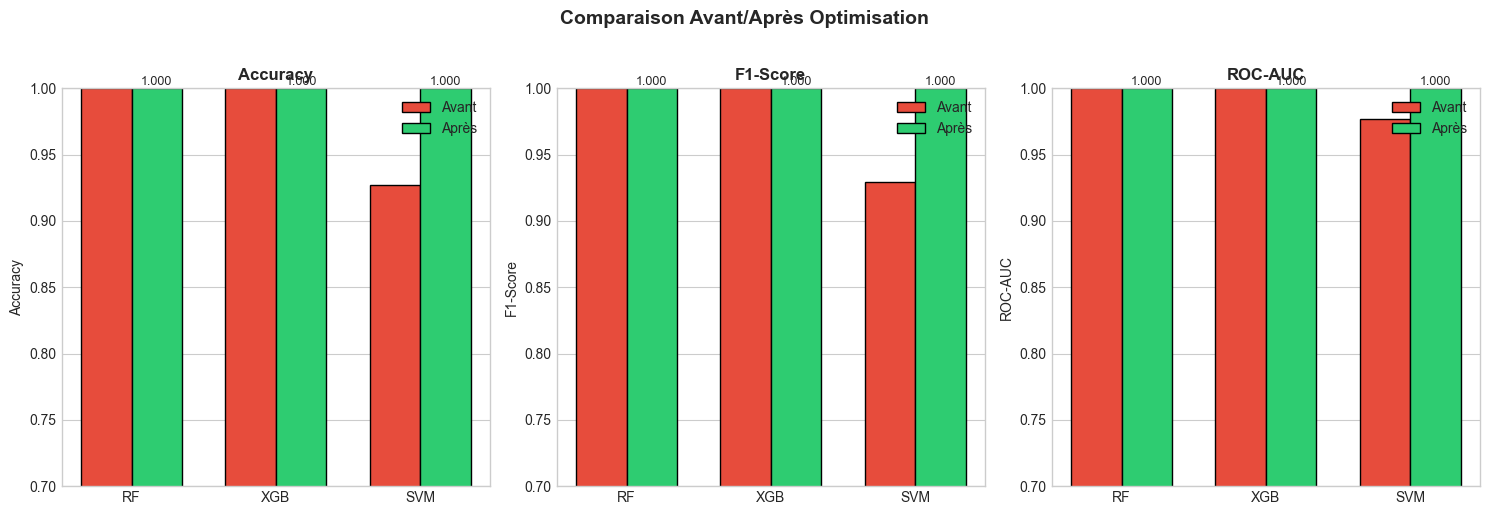

In [15]:
# ============================================================================
# VISUALISATION COMPARATIVE
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['Random_Forest', 'XGBoost', 'SVM']
metrics = ['accuracy', 'f1', 'roc_auc']
titles = ['Accuracy', 'F1-Score', 'ROC-AUC']

x = np.arange(len(models))
width = 0.35

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    before_vals = [results_before[m][metric] for m in models]
    after_vals = [results_after[m][metric] for m in models]
    
    bars1 = ax.bar(x - width/2, before_vals, width, label='Avant', 
                   color=COLORS['before'], edgecolor='black')
    bars2 = ax.bar(x + width/2, after_vals, width, label='Après', 
                   color=COLORS['after'], edgecolor='black')
    
    ax.set_ylabel(title)
    ax.set_title(f'{title}', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['RF', 'XGB', 'SVM'])
    ax.legend()
    ax.set_ylim(0.7, 1.0)
    
    # Ajouter les valeurs
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)

plt.suptitle('Comparaison Avant/Après Optimisation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/hyperparameter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Meilleurs Hyperparamètres

In [16]:
# ============================================================================
# RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES
# ============================================================================

print("\nMEILLEURS HYPERPARAMÈTRES TROUVÉS")
print("="*70)

print("\n1. RANDOM FOREST:")
for param, value in rf_grid.best_params_.items():
    print(f"   {param}: {value}")

print("\n2. XGBOOST:")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print("\n3. SVM:")
for param, value in svm_grid.best_params_.items():
    print(f"   {param}: {value}")


MEILLEURS HYPERPARAMÈTRES TROUVÉS

1. RANDOM FOREST:
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 50

2. XGBOOST:
   subsample: 1.0
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.2
   colsample_bytree: 0.8

3. SVM:
   C: 100
   gamma: scale
   kernel: rbf


## 10. Cross-Validation Finale

In [17]:
# ============================================================================
# CROSS-VALIDATION FINALE SUR MODÈLES OPTIMISÉS
# ============================================================================

print("\nCROSS-VALIDATION (10-Fold) - MODÈLES OPTIMISÉS")
print("="*70)

cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
for name, model in best_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv_10, scoring='accuracy')
    
    cv_results.append({
        'Model': name,
        'CV Mean': scores.mean(),
        'CV Std': scores.std(),
        'CV Min': scores.min(),
        'CV Max': scores.max()
    })
    
    print(f"{name}: {scores.mean():.4f} (±{scores.std():.4f})")

cv_df = pd.DataFrame(cv_results).sort_values('CV Mean', ascending=False)
display(cv_df)


CROSS-VALIDATION (10-Fold) - MODÈLES OPTIMISÉS
Random_Forest: 0.9866 (±0.0159)
XGBoost: 0.9878 (±0.0144)
SVM: 0.9866 (±0.0149)


,Model,CV Mean,CV Std,CV Min,CV Max
1,XGBoost,0.987805,0.014429,0.95122,1.0
0,Random_Forest,0.986585,0.015854,0.95122,1.0
2,SVM,0.986585,0.014886,0.95122,1.0


## 11. Sauvegarde

In [18]:
# ============================================================================
# SAUVEGARDE
# ============================================================================

comparison_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("\u2705 Résultats sauvegardés: hyperparameter_tuning_results.csv")

import joblib
import os
os.makedirs('models_optimized', exist_ok=True)
for name, model in best_models.items():
    joblib.dump(model, f'models_optimized/{name}_optimized.pkl')
print(f"\u2705 {len(best_models)} modèles optimisés sauvegardés")

print("\n" + "="*70)
print("HYPERPARAMETER TUNING TERMINÉ !")
print("="*70)
print(f"\nMeilleur modèle: {cv_df.iloc[0]['Model']}")
print(f"CV Accuracy: {cv_df.iloc[0]['CV Mean']:.4f} (±{cv_df.iloc[0]['CV Std']:.4f})")

✅ Résultats sauvegardés: hyperparameter_tuning_results.csv
✅ 3 modèles optimisés sauvegardés

HYPERPARAMETER TUNING TERMINÉ !

Meilleur modèle: XGBoost
CV Accuracy: 0.9878 (±0.0144)
